In [1]:
import gymnasium as gym
from env import BattleshipEnv
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch as th
import torch.nn as nn
from gymnasium.spaces import Box


In [2]:
class CustomCNN(BaseFeaturesExtractor):
    """
    Custom CNN for smaller input grids like 10x10.
    """
    def __init__(self, observation_space: Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Compute the size of the flattened output of the CNN
        with th.no_grad():
            sample_input = th.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample_input).shape[1]
        
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )
        
    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))


In [3]:
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128)  # Adjust as needed
)


In [4]:
# Create the environment
env = BattleshipEnv(render_mode='human')

# Check the environment
check_env(env)



C:\Users\suyog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\env_checker.py:54: UserWarning: It seems that your observation  is an image but its `dtype` is (float32) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
C:\Users\suyog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\env_checker.py:62: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
C:\Users\suyog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packag

In [5]:
vec_env = DummyVecEnv([lambda: BattleshipEnv(render_mode='human')])

# Create the DQN agent
model = DQN(
    "CnnPolicy",
    vec_env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    learning_rate=1e-4,
    buffer_size=10000,
    learning_starts=1000,
    batch_size=64,
    tau=1e-3,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=1000,
    exploration_fraction=0.999,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05
)

model.learn(total_timesteps=100000)


Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7493     |
|    time_elapsed     | 0        |
|    total_timesteps  | 45       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 7497     |
|    time_elapsed     | 0        |
|    total_timesteps  | 90       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 7997     |
|    time_elapsed     | 0        |
|    total_timesteps  | 152      |
----------------------------------
----------------------------------
| 

In [6]:
# Save the model
model.save("./models/battleship_dqn")

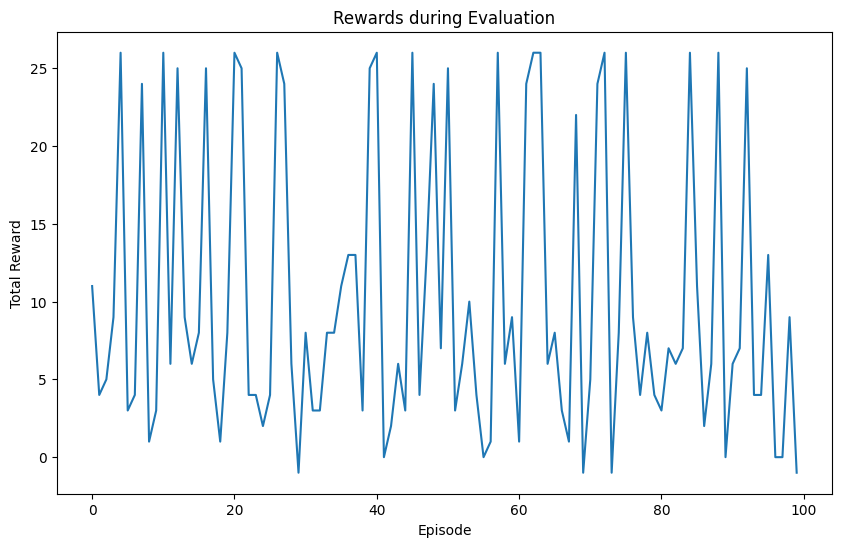

Average reward: 10.149999618530273


In [7]:
# Evaluate the agent
episodes = 100
rewards = []

for episode in range(episodes):
    obs = vec_env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        total_reward += reward
    
    rewards.append(total_reward)

# Plot the rewards
plt.figure(figsize=(10,6))
plt.plot(rewards)
plt.title('Rewards during Evaluation')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Print average reward
print(f"Average reward: {np.mean(rewards)}")

# Optional: Load and continue training
# loaded_model = DQN.load("battleship_dqn", env=vec_env)
# loaded_model.learn(total_timesteps=50000)

In [8]:
def play_game(env, model, games=100):
    """
    Simulate and visualize the bot playing a game of Battleship.

    Args:
    - env: The Battleship environment instance.
    - model: The trained DQN model.

    Returns:
    - total_reward: The total reward the bot earned in the game.
    """
    all_moves = []
    all_rewards = []
    for i in range(games):
        moves=0
        obs = env.reset()
        done = False
        total_reward = 0

        print("Starting test...\n")
        while not done:
            # env.render()  # Render the current state of the environment
            
            # Model predicts the best action
            action, _ = model.predict(obs, deterministic=True)
            
            # Step in the environment
            obs, reward, done, info = env.step(action)
            total_reward += reward

            # print(obs, reward, done)
            moves+=1
            
        # env.render()  # Render the final state of the environment
        all_moves.append(moves)
        all_rewards.append(total_reward)
        print("Game over!")
        print(f"Total Reward: {total_reward}")
    return all_moves, all_rewards


In [9]:
moves, rewards = play_game(vec_env, model)

Starting test...

Game over!
Total Reward: [25.]
Starting test...

Game over!
Total Reward: [1.]
Starting test...

Game over!
Total Reward: [6.]
Starting test...

Game over!
Total Reward: [2.]
Starting test...

Game over!
Total Reward: [0.]
Starting test...

Game over!
Total Reward: [5.]
Starting test...

Game over!
Total Reward: [9.]
Starting test...

Game over!
Total Reward: [26.]
Starting test...

Game over!
Total Reward: [7.]
Starting test...

Game over!
Total Reward: [0.]
Starting test...

Game over!
Total Reward: [26.]
Starting test...

Game over!
Total Reward: [-1.]
Starting test...

Game over!
Total Reward: [9.]
Starting test...

Game over!
Total Reward: [25.]
Starting test...

Game over!
Total Reward: [8.]
Starting test...

Game over!
Total Reward: [0.]
Starting test...

Game over!
Total Reward: [4.]
Starting test...

Game over!
Total Reward: [25.]
Starting test...

Game over!
Total Reward: [7.]
Starting test...

Game over!
Total Reward: [-1.]
Starting test...

Game over!
Tota

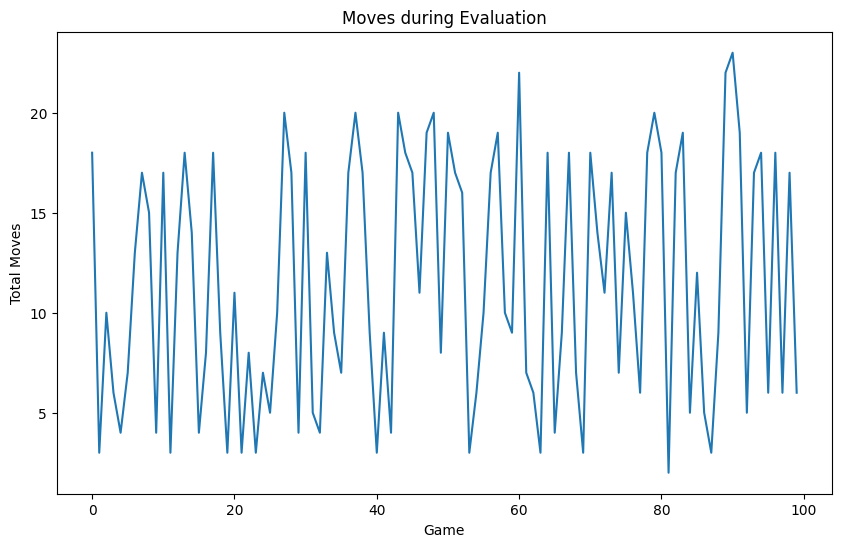

In [10]:
plt.figure(figsize=(10,6))
plt.plot(moves)
plt.title('Moves during Evaluation')
plt.xlabel('Game')
plt.ylabel('Total Moves')
plt.show()